# Implementation of Sentence BERT
This notebook takes the reader through the main results presentet in the exam project in Deep Learning at DTU.

In [1]:
# install if run on Colab
#!pip install pytorch-pretrained-bert pytorch-nlp scikit-learn matplotlib #tensorflow keras
#!pip install -U sentence-transformers

In [1]:
# imports libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
from sklearn.metrics import f1_score
import io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# specify CPU or GPU as device
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(0))
else:
    device = 'cpu'
print(f'device = {device}')

Tesla K80
device = cuda


### Load data from Google Drive to pandas DataFrame

In [4]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls drive/'My Drive'

'Colab Notebooks'   dtu_project  'Laef Classification'


###Load data of EU skills Taxonomy (ESCO).
Data contains skills denoted as a query and an appurtenant description denoted as a document.

In [4]:
# Load data of EU skills Taxonomy from CSV
drive_path = 'drive/My Drive/dtu_project'

#df = pd.read_csv(drive_path + r'/skills_description.csv', sep='\t', encoding='utf-8')
df = pd.read_csv(r'data\skills_description.csv', sep='\t', encoding='utf-8')
df = df.rename(columns={'preferredLabel':'query', 'description': 'documents'})
df = df[['query', 'documents']]

df.head()

,query,documents
0,lede musikalsk personale,Tildele og forvalte personaleopgaver på område...
1,føre tilsyn med fængselsprocedurer,Føre tilsyn med driften af et fængsel eller an...
2,anvende antioppressiv praksis,"Identificere undertrykkelse i samfund, økonomi..."
3,kontrollere overensstemmelse med jernbaneforsk...,"Inspicere rullende materiel, komponenter og sy..."
4,identificere tilgængelige tjenester,"Identificere de forskellige tjenester, der er ..."


## Load pretrained SBERT model

In [5]:
SBERT = SentenceTransformer('sentence-transformers/stsb-xlm-r-multilingual')

Downloading: 100%|██████████| 574/574 [00:00<00:00, 87.9kB/s]
Downloading: 100%|██████████| 3.70k/3.70k [00:00<00:00, 411kB/s]
Downloading: 100%|██████████| 229/229 [00:00<00:00, 115kB/s]
Downloading: 100%|██████████| 1.11G/1.11G [04:23<00:00, 4.22MB/s]
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 17.7kB/s]
Downloading: 100%|██████████| 5.07M/5.07M [00:14<00:00, 352kB/s]
Downloading: 100%|██████████| 150/150 [00:00<00:00, 30.1kB/s]
Downloading: 100%|██████████| 9.10M/9.10M [00:02<00:00, 3.37MB/s]
Downloading: 100%|██████████| 190/190 [00:00<00:00, 29.3kB/s]


### Define my SBERT model
Encodes pandas series of strings

In [6]:
class my_SBERT(nn.Module):
    '''Return embeddings of pandas Serie of dtype string'''
    def __init__(self):
        super(my_SBERT, self).__init__()
        self.SBERT = SBERT.to(device)  
        ### New layers:
        #self.linear1 = nn.Linear(768, 132).to(device)
          
    def forward(self, text):
        embeddings = torch.tensor(SBERT.encode(list(text))).to(device)
        #embeddings = self.linear1(embeddings).to(device)
        #embeddings = F.normalize(embeddings, p=2.0, dim=1, eps=1e-12, out=None)
        #embeddings = F.softmax(embeddings, dim=1)
        return embeddings

my_SBERT = my_SBERT()

# Print my_SBERT info:
my_SBERT.to(device)

my_SBERT(
  (SBERT): SentenceTransformer(
    (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: XLMRobertaModel 
    (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  )
)

# Create embeddings.

In [7]:
# Create document embeddings of skill descriptions, i.e. embeddings of the categories
desciption_embeddings = my_SBERT(df['documents'])
print('Shape of all document embeddings: ', desciption_embeddings.shape)

# Create query embeddings of skills
skills_embeddings = my_SBERT(df['query'])
print('Shape of all query embeddings:  ', skills_embeddings.shape)

Shape of all document embeddings:  torch.Size([13485, 768])
Shape of all query embeddings:   torch.Size([13485, 768])


# Define functions to measure contextural similarity

In [8]:
def SingleMaxSim(q, D):
    '''Takes in the embeddings of one query, q, and all documents' embeddings, D.
        Return tensor of the query's similarity scores to all documents in D, maxSim_val
        and an ordered tensor of the index of the most similar documents.'''
    
    # multiply the same query q against all documents (in D)
    batch_mm = torch.matmul(q, torch.t(D))
    
    #maks, maks_id = torch.max(batch_mm, dim=0) 
    
    # find the k most similar query -document pairs
    maxSim_val, maks_idx = torch.topk(batch_mm, D.shape[0], largest=True)
    
    return maxSim_val, maks_idx

In [9]:
def MaxSim(Q, D):
    '''Takes in the embeddings of all queries, Q, and all documents' embeddings, D.
        Return tensor of all queries's similarity scores to all documents in D, maxSim_val
        and an ordered tensor of the index of the most similar documents.'''
    
    # multiply the same query q against all documents (in D)
    batch_mm = torch.matmul(Q, torch.t(D))
    
    #maks, maks_id = torch.max(batch_mm, dim=0) 
    
    # find the k most similar query -document pairs
    maxSim_val, maks_idx = torch.topk(batch_mm, D.shape[0], largest=True)
    
    return maxSim_val, maks_idx

In [10]:
def accuracy_top_k(batch_size, pred_idx):
    '''Return the accuracy score of correct predictions in top k'''
    yes_no = []
    for i in range(batch_size):
        yes_no.append(i in pred_idx[i])

    return np.round((np.sum(yes_no) / batch_size)*100,2)

## MaxSim implementation

In [12]:
batch_size = skills_embeddings.shape[0]

# Calculate MaxSim score and save the index of documents most similar to each query
maxSim_val, maks_idx = MaxSim(Q=skills_embeddings, D=desciption_embeddings)

# Due to the unchanged order of Q - IDs are also the true labls
y_true = [x for x in range(batch_size)]
y_pred = maks_idx[:, 0].to('cpu')

# Calculate and display f1-score
print('f1 score: ', round(f1_score(y_true, y_pred, average='weighted'),4))

# Calculate correct and wrong predictions
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

# Calculate and display accuracy score
print(f'right {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs)*100,2)}% accuracy')

f1 score:  0.1489
right 2792 out of 13485 
 20.7% accuracy


In [14]:
# In top k

# Similarity calculation
mm = torch.matmul(skills_embeddings, torch.t(desciption_embeddings))

# find to k most similar
for k in [1, 3, 5, 10, 20, 50]:
    print(f'Top {k} accuracy: {accuracy_top_k(batch_size, pred_idx=torch.topk(mm, k=k, largest=True)[1])}%' )

Top 1 accuracy: 20.7%
Top 3 accuracy: 34.2%
Top 5 accuracy: 41.34%
Top 10 accuracy: 50.73%
Top 20 accuracy: 60.07%
Top 50 accuracy: 70.92%


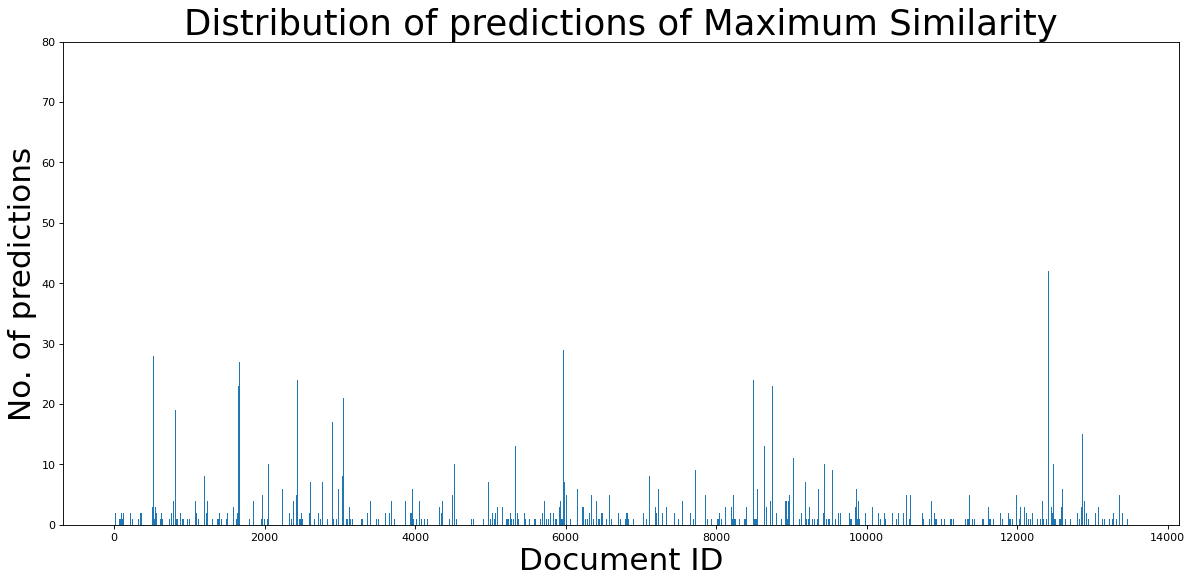

In [15]:
# Distribution of "predictions"
plt.figure(figsize=(18, 8), dpi=80)
plt.hist(most_similar_docID, bins=Q.shape[0])
plt.title('Distribution of predictions of Maximum Similarity', fontsize=32)
plt.xlabel('Document ID', fontsize=28)

plt.ylabel('No. of predictions', fontsize=28)
plt.ylim(0,80)

#plt.savefig(r'J:\VOA\MABI\Deep Learning\my_DTU_project\images\xlm_distribution_MaxSim.png')
plt.show()

# Implementation of MINIMUM Eucledian distance

In [15]:
def MinEuc(Q,D):
    EucDist = torch.cdist(Q, D, p=2, compute_mode = 'use_mm_for_euclid_dist_if_necessary')

    # find most similar
    min_idx = torch.topk(EucDist, Q.shape[0], largest=False)[1]

    return min_idx[:, 0:50]

In [16]:
batch_size = skills_embeddings.shape[0] 
min_idx = MinEuc(Q=skills_embeddings, D=desciption_embeddings)

# Due to the unchanged order - IDs are also the true labls
y_true = [x for x in range(batch_size)]
y_pred = min_idx[:, 0].to('cpu') #np.array(min_idx)

# Calculate and display f1-score
print('f_1score: ', round(f1_score(y_true, y_pred, average='weighted'),4))

# Calculate correct and wrong predictions
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

# Calculate and display accuracy
print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs)*100,2)}% accuracy')


f_1score:  0.1756
rights: 3009 out of 13485 
 22.31% accuracy


In [17]:
def accuracy_top_k(batch_size, k, pred_idx):
    '''Return the accuracy score of correct predictions in top k'''
    yes_no = []
    for i in range(batch_size):
        yes_no.append(i in pred_idx[i][:k])

    return np.round((np.sum(yes_no) / batch_size)*100,2)

In [18]:
# In top k

# find to k most similar
for k in [1, 3, 5, 10, 20, 50]:
    print(f'Top {k} accuracy: {accuracy_top_k(batch_size, k, pred_idx=min_idx)}%' )

Top 1 accuracy: 22.31%
Top 3 accuracy: 35.35%
Top 5 accuracy: 41.77%
Top 10 accuracy: 50.4%
Top 20 accuracy: 58.88%
Top 50 accuracy: 69.57%


## Play around and test any skill you can think of

In [19]:
# write anything here:
raw_skill = "tålmodighed"

encoding_skill = my_SBERT([raw_skill])[0]

ordered_match = SingleMaxSim(q=encoding_skill, D=desciption_embeddings)[1]

k=10
df.iloc[ordered_match[:k].to('cpu')]

,query,documents
5907,kunne sidde ned i lange perioder,Have tålmodighed til at blive siddende i lang ...
1457,udvise tålmodighed,Have tålmodighed ved at forholde sig til uvent...
12940,være vedholdende,Fortsætte sine opgaver til trods for træthed e...
11014,håndtere stress,Bevare en afbalanceret mental tilstand og en e...
11277,have gode manerer ved sengekanten,"Sørge for, at patienterne føler sig godt tilpa..."
12484,sikre tjenestebrugernes tillid,Etablere og opretholde kundens tiltro og tilli...
12424,udvise diplomatiske evner,Håndtere mennesker på en følsom og taktfuld måde.
3366,give sikre instrukser om fitness,Sørge for sikker og effektiv fitnessinstruktion.
1522,tage fat om spørgsmål vedrørende folkesundhed,"Fremme sund praksis og adfærd for at sikre, at..."
8908,håndtere stressede situationer,Håndtere og styre meget stressende situationer...
